In [1]:
import sys
sys.executable

'c:\\Users\\domin\\VSCode-projects\\gan-generator\\.venv\\Scripts\\python.exe'

In [2]:
import torch

print("CUDA available:", torch.cuda.is_available())


CUDA available: True


In [3]:
import scipy
print("SciPy version:", scipy.__version__)

SciPy version: 1.17.0


In [3]:
import tensorflow as tf 
print(tf.test.is_built_with_cuda()) 

ModuleNotFoundError: No module named 'tensorflow'

In [4]:
print("hello")

hello


# Task
Train and evaluate a Convolutional Neural Network (CNN) model to classify real and fake faces using the data from the Kaggle dataset "xhlulu/140k-real-and-fake-faces".

## Pobranie i rozpakowanie danych

### Subtask:
Pobierz i rozpakuj dane z Kaggle dataset 'xhlulu/140k-real-and-fake-faces', przygotowując pliki do dalszego przetwarzania.


**Reasoning**:
The first instruction is to install the Kaggle library. This requires using `pip install`.



In [ ]:
# to jest niepotrzebne, bo wrzuciłam sama plik z danymi
print('Installing kaggle library...')
!pip install kaggle
print('Kaggle library installed.')

### Load Kaggle Credentials

To download data from Kaggle, you need to provide your API credentials. Follow these steps:

1.  **Create an API Token**: If you haven't already, go to your Kaggle account page (https://www.kaggle.com/settings/account) and click on 'Create New API Token'. This will download a `kaggle.json` file.
2.  **Upload `kaggle.json`**: Upload the downloaded `kaggle.json` file to this Colab environment. You can do this by clicking the 'Files' icon on the left sidebar, then 'Upload to session storage', and select your `kaggle.json` file.
3.  **Move `kaggle.json` to the correct directory**: We need to move this file to the `.kaggle` directory so the Kaggle API can find it. Run the next code cell to create the directory and move the file.

**Reasoning**:
The previous step provided instructions for obtaining and uploading the Kaggle API key. Now, we need to create the `.kaggle` directory if it doesn't exist and move the uploaded `kaggle.json` file into it so that the Kaggle API can authenticate correctly.



In [ ]:
# tego też w takim razie nie potrzeba
pip install opendatasets

In [ ]:
# nie potrzeba, pobraałam .zip z kaggle i kozpakowałam w katalogu projektu
import opendatasets as od
od.download("https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces")

**Reasoning**:
The previous step provided instructions for obtaining and uploading the Kaggle API key. Now, we need to create the `.kaggle` directory if it doesn't exist and move the uploaded `kaggle.json` file into it so that the Kaggle API can authenticate correctly.



# Task
Train and evaluate a Convolutional Neural Network (CNN) model to classify real and fake faces using the data from the Kaggle dataset "xhlulu/140k-real-and-fake-faces".

## Przygotowanie danych do modelowania

### Subtask:
Załaduj obrazy, zastosuj wstępne przetwarzanie (np. zmiana rozmiaru, normalizacja), podziel dane na zestawy treningowe, walidacyjne i testowe oraz przygotuj generatory danych dla modelu CNN.


**Reasoning**:
The first step is to define the base path for the dataset and construct the full paths for the training, validation, and test directories, as per the instructions. This will prepare the necessary directory variables for the next steps.



In [ ]:
# ta komórka nie jest potrzebna
import os

# Define the base path for the dataset
base_path = '/content/140k-real-and-fake-faces'

# Construct paths to the training, validation, and test directories
train_dir = os.path.join(base_path, 'train')
valid_dir = os.path.join(base_path, 'valid')
test_dir = os.path.join(base_path, 'test')

print(f"Training data directory: {train_dir}")
print(f"Validation data directory: {valid_dir}")
print(f"Test data directory: {test_dir}")

Training data directory: /content/140k-real-and-fake-faces\train
Validation data directory: /content/140k-real-and-fake-faces\valid
Test data directory: /content/140k-real-and-fake-faces\test


**Reasoning**:
The next step, according to the instructions, is to define constants for image height, image width, batch size, and the number of classes. These constants will be used in subsequent steps for data preprocessing and model configuration.



In [4]:
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32
NUM_CLASSES = 2

print(f"Image Height: {IMG_HEIGHT}")
print(f"Image Width: {IMG_WIDTH}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Number of Classes: {NUM_CLASSES}")

Image Height: 150
Image Width: 150
Batch Size: 32
Number of Classes: 2


**Reasoning**:
Following the instructions, the next step is to import `ImageDataGenerator` from `tensorflow.keras.preprocessing.image` to prepare for creating data generators.



In [9]:
# execute, bo używam do augmentacji danych
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("ImageDataGenerator imported successfully.")

ImageDataGenerator imported successfully.


**Reasoning**:
As per the instructions, the next step is to create an instance of `ImageDataGenerator` for the training data, applying various data augmentation techniques such as rescaling, rotation, zooming, horizontal flipping, and width/height shifts.



In [11]:
# execute, bo przyda się do augumentacji danych treningowych
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

print("ImageDataGenerator for training data with augmentation created.")

ImageDataGenerator for training data with augmentation created.


**Reasoning**:
As per the instructions, the next step is to create two instances of `ImageDataGenerator` for the validation and test datasets. These generators should only perform pixel rescaling (normalization) and not apply any data augmentation techniques.



In [12]:
# tu jest tensorflow, ale mogę tego użyć do przygotowania danych walidacyjnych i testowych
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("ImageDataGenerator for validation data created.")
print("ImageDataGenerator for test data created.")

ImageDataGenerator for validation data created.
ImageDataGenerator for test data created.


**Reasoning**:
As per the instructions, the next step is to use the `flow_from_directory` method for each `ImageDataGenerator` instance (`train_datagen`, `valid_datagen`, and `test_datagen`) to load images directly from their respective directories. This involves setting the `target_size`, `batch_size`, and `class_mode` for each generator.



In [ ]:
# to nie jest potrzebne, bo poniżej jest poprawione
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # Keep data in order for evaluation
)

print("Data generators created: train_generator, valid_generator, test_generator.")

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Data generators created: train_generator, valid_generator, test_generator.


**Reasoning**:
The `FileNotFoundError` indicates that the paths for the training, validation, and test image directories are incorrect. Based on the common structure of the 'xhlulu/140k-real-and-fake-faces' dataset after being downloaded and extracted by `opendatasets`, the actual image folders are typically nested within an additional directory, often named 'real_and_fake_faces'. Therefore, the `base_path` needs to be updated to reflect this nested structure before proceeding with data loading.



# Task
Create data generators (`train_generator`, `valid_generator`, `test_generator`) using `ImageDataGenerator` for the training, validation, and test datasets with the updated directory paths `/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train`, `/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid`, and `/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test`. Apply appropriate transformations (rescaling, augmentation for training) and set `target_size`, `batch_size`, and `class_mode`.

## Aktualizacja ścieżek do danych

### Subtask:
Zaktualizuj zmienne ścieżek `train_dir`, `valid_dir` i `test_dir`, aby wskazywały na prawidłowe lokalizacje katalogów z danymi, które podałeś: `/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train`, `/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid`, `/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test`.


**Reasoning**:
The previous attempt to create data generators failed due to incorrect file paths. According to the provided instructions, the base path for the dataset needs to be updated to `/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake`, and then the `train_dir`, `valid_dir`, and `test_dir` variables must be reconstructed using this new base path to correctly point to the image directories.



In [13]:
import os

# Update the base path for the dataset
base_path = './real-and-fake-detection/real_vs_fake/real-vs-fake'

# Reconstruct paths to the training, validation, and test directories
train_dir = os.path.join(base_path, 'train')
valid_dir = os.path.join(base_path, 'valid')
test_dir = os.path.join(base_path, 'test')

print(f"Updated Training data directory: {train_dir}")
print(f"Updated Validation data directory: {valid_dir}")
print(f"Updated Test data directory: {test_dir}")

Updated Training data directory: ./real-and-fake-detection/real_vs_fake/real-vs-fake\train
Updated Validation data directory: ./real-and-fake-detection/real_vs_fake/real-vs-fake\valid
Updated Test data directory: ./real-and-fake-detection/real_vs_fake/real-vs-fake\test


**Reasoning**:
Now that the directory paths have been updated, the next step is to create the data generators (`train_generator`, `valid_generator`, `test_generator`) using the `flow_from_directory` method from the previously defined `ImageDataGenerator` instances and the corrected paths. This will load the images, apply transformations, and prepare them for model training and evaluation.



# Task
Create data generators (`train_generator`, `valid_generator`, `test_generator`) using `ImageDataGenerator` for the training, validation, and test datasets, leveraging the updated directory paths: "/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train", "/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid", and "/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test". Apply appropriate transformations (rescaling, augmentation for training) and set `target_size`, `batch_size`, and `class_mode`.

## Przygotowanie generatorów danych

### Subtask:
Utwórz generatory danych (`train_generator`, `valid_generator`, `test_generator`) z `ImageDataGenerator` dla danych treningowych, walidacyjnych i testowych, wykorzystując zaktualizowane ścieżki. Zastosuj odpowiednie transformacje (skalowanie, augmentacja dla treningu) i ustaw `target_size`, `batch_size` oraz `class_mode`.


**Reasoning**:
Now that the directory paths have been updated, the next step is to create the data generators (`train_generator`, `valid_generator`, `test_generator`) using the `flow_from_directory` method from the previously defined `ImageDataGenerator` instances and the corrected paths. This will load the images, apply transformations, and prepare them for model training and evaluation.



In [14]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # Keep data in order for evaluation
)

print("Data generators created: train_generator, valid_generator, test_generator.")

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Data generators created: train_generator, valid_generator, test_generator.


## Zbudowanie modelu CNN

### Subtask:
Zdefiniuj architekturę konwolucyjnej sieci neuronowej (CNN) odpowiedniej do binarnej klasyfikacji obrazów twarzy (prawdziwa/wygenerowana). Model powinien zawierać warstwy konwolucyjne, poolingowe i gęste.


**Reasoning**:
The first instruction is to import the necessary modules from `tensorflow.keras` to build the CNN model. This includes `Sequential`, `Conv2D`, `MaxPooling2D`, `Flatten`, `Dense`, and `Dropout`.



In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

print("Keras modules imported successfully for model definition.")

Keras modules imported successfully for model definition.


**Reasoning**:
Following the instructions, the next step is to initialize a Sequential model, add convolutional and pooling layers, flatten the output, add dense layers with dropout for regularization, and finally, add a dense output layer with a 'sigmoid' activation function for binary classification. After defining the model, its summary will be printed to review the architecture.



In [16]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

print("CNN model architecture defined.")
model.summary()

c:\Users\domin\VSCode-projects\face-clasificator\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CNN model architecture defined.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

**Reasoning**:
The CNN model architecture has been successfully defined and its summary printed, as confirmed by the execution output. The warning received is informational and does not prevent the model from being compiled and used. The next logical step in the model building process is to compile the model by specifying the optimizer, loss function, and metrics for training.



In [ ]:
# tego nie używam
from tensorflow.keras.metrics import Precision, Recall, AUC

In [ ]:
# tego nie
from torchmetrics.classification import (
    BinaryPrecision,
    BinaryRecall,
    BinaryAUROC
)

In [7]:
# 1. uruchamiać - niezbędne importy
import os
from pathlib import Path
import datetime

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from torchmetrics.classification import (
    BinaryPrecision,
    BinaryRecall,
    BinaryAUROC
)

from torch.utils.tensorboard import SummaryWriter

In [8]:
# 2. Device CPU/GPU + wymuszenie inicjalizacji CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# wymuszenie inicjalizacji CUDA (ważne na laptopach)
if device.type == "cuda":
    _ = torch.zeros(1, device=device)
    print(torch.cuda.get_device_name(0))

Using device: cuda
NVIDIA GeForce RTX 2070 with Max-Q Design


In [9]:
# 3. Transforms i dane (zamiennik dla ImageDataGenerator z Keras)
IMAGE_SIZE = 128
BATCH_SIZE = 32

train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [10]:
precision = BinaryPrecision().to(device)
recall = BinaryRecall().to(device)
auc = BinaryAUROC().to(device)

In [ ]:
# nie uruchamiać
# ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    filepath="checkpoints/best_model.h5",
    monitor="val_auc",
    mode="max",
    save_best_only=True,
    verbose=1
)

In [ ]:
# nie uruchamiać
best_auc = 0.0

if val_auc > best_auc:
    best_auc = val_auc
    torch.save(model.state_dict(), "checkpoints/best_model.pt")

In [ ]:
# nie używać
# EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# tego nie
patience = 5
counter = 0
best_loss = float("inf")

if val_loss < best_loss:
    best_loss = val_loss
    counter = 0
else:
    counter += 1
    if counter >= patience:
        print("Early stopping")
        break

In [ ]:
# tego nie
# ReduceLROnPlateau
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [ ]:
# tego nie
# TensorBoard
from tensorflow.keras.callbacks import TensorBoard
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

In [ ]:
# bez tego, bo model kompiluję później, to jest do tensorflow
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

print("Model compiled successfully.")

Model compiled successfully.


In [12]:
# 4. Dataloader
DATA_DIR = Path("./real-and-fake-detection/real_vs_fake/real-vs-fake")

train_dataset = datasets.ImageFolder(
    root=DATA_DIR / "train",
    transform=train_transforms
)

val_dataset = datasets.ImageFolder(
    root=DATA_DIR / "valid",
    transform=val_transforms
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print("Classes:", train_dataset.classes)


Classes: ['fake', 'real']


In [13]:
# 5. Model CNN/transfer learning - wykorzystanie ResNet18
model = models.resnet18(weights="DEFAULT")

# zamiana ostatniej warstwy na binarną
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)

model = model.to(device)

In [14]:
# 6. Loss, optimizer, scheduler
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.3,
    patience=3,
    min_lr=1e-6
)

In [15]:
# 7. Metryki - Precision, Recall, AUC
precision = BinaryPrecision().to(device)
recall = BinaryRecall().to(device)
auc = BinaryAUROC().to(device)

In [16]:
# 8. Calbacki
EPOCHS = 20 # 10, 20, 40, 80
PATIENCE = 5

best_val_auc = 0.0
early_stop_counter = 0

CHECKPOINT_DIR = Path("checkpoints")
CHECKPOINT_DIR.mkdir(exist_ok=True)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter(log_dir=log_dir)


## Trenowanie modelu CNN

### Subtask:
Wytrenuj model CNN, korzystając z przygotowanych generatorów danych.


**Reasoning**:
The next step is to train the CNN model using the `fit()` method, passing the `train_generator` for training and `valid_generator` for validation. I will calculate the `steps_per_epoch` and `validation_steps` using the number of samples from the generators and the defined `BATCH_SIZE`. The training history will be stored in a `history` variable.



In [18]:
import scipy
print("SciPy version:", scipy.__version__)

SciPy version: 1.17.0


In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [20]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1111589156608958353
xla_global_id: -1
]


In [ ]:
# tego nie używam
EPOCHS = 20

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    callbacks=[
        checkpoint_cb,
        earlystop_cb,
        lr_cb,
        tensorboard_cb
    ]
)

print(f"Model training completed for {EPOCHS} epochs.")

In [17]:
# 9. Trening
for epoch in range(EPOCHS):
    # ===== TRAIN =====
    model.train()
    train_loss = 0.0

    for x, y in train_loader:
        x = x.to(device)
        y = y.float().to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # ===== VALIDATION =====
    model.eval()
    val_loss = 0.0

    precision.reset()
    recall.reset()
    auc.reset()

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.float().to(device).unsqueeze(1)

            outputs = model(x)
            loss = criterion(outputs, y)
            val_loss += loss.item()

            precision.update(outputs, y)
            recall.update(outputs, y)
            auc.update(outputs, y)

    val_loss /= len(val_loader)
    val_precision = precision.compute().item()
    val_recall = recall.compute().item()
    val_auc = auc.compute().item()

    scheduler.step(val_loss)

    # ===== LOGGING =====
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("AUC/val", val_auc, epoch)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"train_loss={train_loss:.4f} | "
        f"val_loss={val_loss:.4f} | "
        f"val_auc={val_auc:.4f}"
    )

    # ===== CHECKPOINT =====
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        early_stop_counter = 0
        torch.save(model.state_dict(), CHECKPOINT_DIR / "best_model.pt")
        print("✅ Best model saved")
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print("⛔ Early stopping triggered")
            break


Epoch 1/20 | train_loss=0.1856 | val_loss=0.1209 | val_auc=0.9909
✅ Best model saved
Epoch 2/20 | train_loss=0.0695 | val_loss=0.0820 | val_auc=0.9969
✅ Best model saved
Epoch 3/20 | train_loss=0.0476 | val_loss=0.0539 | val_auc=0.9981
✅ Best model saved
Epoch 4/20 | train_loss=0.0346 | val_loss=0.0521 | val_auc=0.9985
✅ Best model saved
Epoch 5/20 | train_loss=0.0270 | val_loss=0.0735 | val_auc=0.9976
Epoch 6/20 | train_loss=0.0248 | val_loss=0.0476 | val_auc=0.9987
✅ Best model saved
Epoch 7/20 | train_loss=0.0196 | val_loss=0.0394 | val_auc=0.9990
✅ Best model saved
Epoch 8/20 | train_loss=0.0183 | val_loss=0.1118 | val_auc=0.9988
Epoch 9/20 | train_loss=0.0168 | val_loss=0.0341 | val_auc=0.9992
✅ Best model saved
Epoch 10/20 | train_loss=0.0144 | val_loss=0.0288 | val_auc=0.9995
✅ Best model saved
Epoch 11/20 | train_loss=0.0136 | val_loss=0.0335 | val_auc=0.9994
Epoch 12/20 | train_loss=0.0125 | val_loss=0.0379 | val_auc=0.9993
Epoch 13/20 | train_loss=0.0116 | val_loss=0.0331 | v

In [18]:
# 10. Koniec treningu:
writer.close()
print("Training finished.")

Training finished.


In [19]:
# część druga - ewaluacja modelu na zbiorze testowym
# 1. zładowanie najlepszego modelu (ale nie wiem, czy tak zostanie)
model.load_state_dict(
    torch.load(CHECKPOINT_DIR / "best_model.pt", map_location=device)
)
model.eval()
print("Best model loaded for evaluation.")

Best model loaded for evaluation.


In [ ]:
# jednak nie działa
model.summary()

In [20]:
# 2. Test transforms - bez augumentacji
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

In [21]:
# 3. test dataset + loader
TEST_DIR = "./real-and-fake-detection/real_vs_fake/real-vs-fake/test"

test_dataset = ImageFolder(
    root=TEST_DIR,
    transform=test_transforms
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print("Classes:", test_dataset.classes)

Classes: ['fake', 'real']


In [22]:
# 4. metryki
from torchmetrics import Accuracy, Precision, Recall, AUROC

test_acc = Accuracy(task="binary").to(device)
test_precision = Precision(task="binary").to(device)
test_recall = Recall(task="binary").to(device)
test_auc = AUROC(task="binary").to(device)

In [23]:
# 5. test loop
test_loss = 0.0
criterion = torch.nn.BCEWithLogitsLoss()

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.float().to(device).unsqueeze(1)

        outputs = model(x)
        loss = criterion(outputs, y)
        test_loss += loss.item()

        test_acc.update(outputs, y)
        test_precision.update(outputs, y)
        test_recall.update(outputs, y)
        test_auc.update(outputs, y)

test_loss /= len(test_loader)

print("===== TEST RESULTS =====")
print(f"Loss:      {test_loss:.4f}")
print(f"Accuracy:  {test_acc.compute().item():.4f}")
print(f"Precision: {test_precision.compute().item():.4f}")
print(f"Recall:    {test_recall.compute().item():.4f}")
print(f"AUC:       {test_auc.compute().item():.4f}")

===== TEST RESULTS =====
Loss:      0.5065
Accuracy:  0.9933
Precision: 0.9950
Recall:    0.9916
AUC:       0.9996


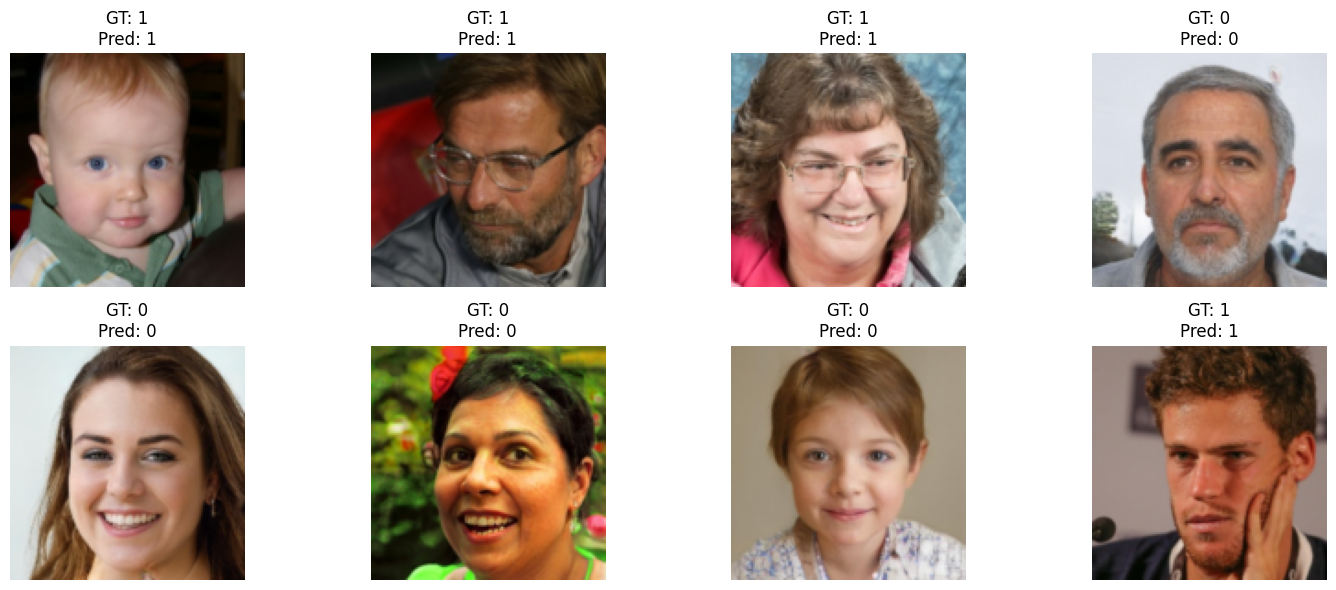

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import random

model.eval()

# 1️⃣ Zbierz wszystkie obrazy i etykiety w pamięci (tylko jeśli test set nie jest gigantyczny)
all_images = []
all_labels = []

for x, y in test_loader:
    all_images.append(x)
    all_labels.append(y)

all_images = torch.cat(all_images, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# 2️⃣ Wybierz 8 losowych indeksów
indices = random.sample(range(len(all_images)), 8)

images = all_images[indices].to(device)
labels = all_labels[indices].to(device).unsqueeze(1)

# 3️⃣ Predykcje modelu
with torch.no_grad():
    outputs = model(images)
    preds = (outputs > 0.5).float()

# 4️⃣ Przenieś do CPU do wyświetlenia
images = images.cpu()
labels = labels.cpu()
preds = preds.cpu()

# 5️⃣ Wyświetlenie
fig, axes = plt.subplots(2, 4, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    img = images[i].permute(1, 2, 0)  # C,H,W -> H,W,C
    img = (img * 0.5 + 0.5).numpy()  # denormalizacja
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"GT: {int(labels[i].item())}\nPred: {int(preds[i].item())}")
plt.tight_layout()
plt.show()


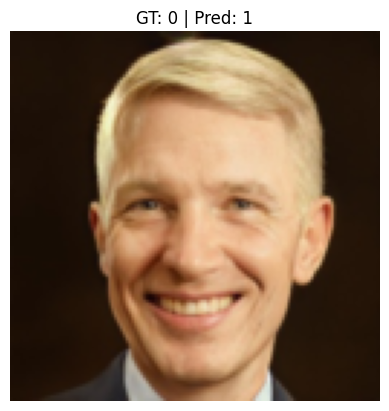

In [26]:
# szukam obrazu, z którym model się pomylił
import matplotlib.pyplot as plt

model.eval()
false_images = []
false_labels = []
false_preds = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device).unsqueeze(1).float()
        outputs = model(x)
        preds = (outputs > 0.5).float()
        
        mask = (preds != y).squeeze()  # True tam gdzie błąd
        if mask.sum() > 0:
            false_images.append(x[mask].cpu())
            false_labels.append(y[mask].cpu())
            false_preds.append(preds[mask].cpu())

# Spłaszcz listy
if false_images:
    false_images = torch.cat(false_images)
    false_labels = torch.cat(false_labels)
    false_preds = torch.cat(false_preds)

    # Pokaż pierwszy false example
    img = false_images[0].permute(1, 2, 0) * 0.5 + 0.5  # denormalizacja
    plt.imshow(img.numpy())
    plt.axis('off')
    plt.title(f"GT: {int(false_labels[0].item())} | Pred: {int(false_preds[0].item())}")
    plt.show()
else:
    print("Brak błędnych predykcji w test_loader 🙂")


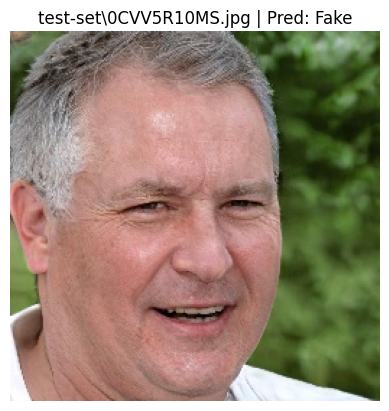

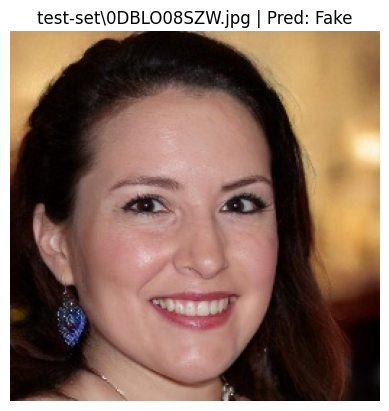

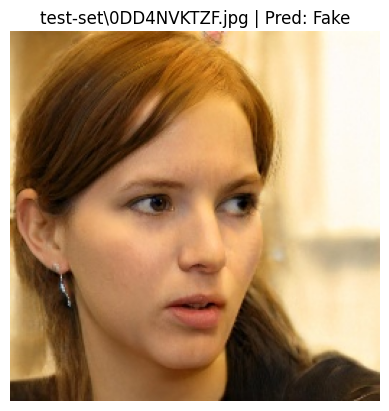

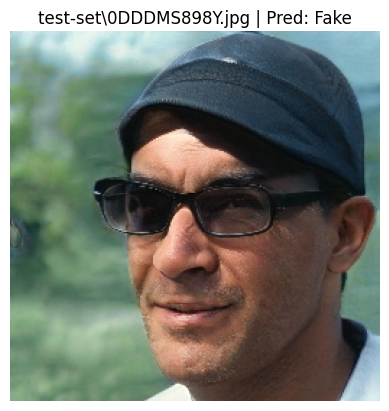

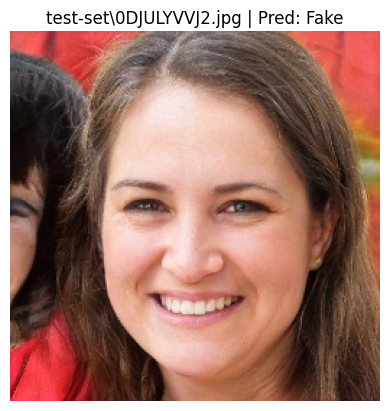

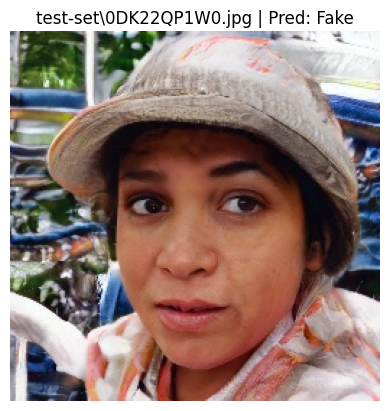

In [29]:
from PIL import Image
import glob
import torch
from torchvision import transforms

model.eval()

# Transformacje (takie same jak dla test_loader)
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

# Wczytaj wszystkie obrazy z folderu
image_paths = glob.glob("test-set/*.*")  # .jpg, .png itd.

for path in image_paths:
    img = Image.open(path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)  # batch=1
    
    with torch.no_grad():
        output = model(input_tensor)
        pred = (output > 0.5).float().item()
    
    plt.imshow(np.array(img))
    plt.axis('off')
    plt.title(f"{path.split('/')[-1]} | Pred: {'Real' if pred==1 else 'Fake'}")
    plt.show()